

7. Вивести важливість ознак для моделі, які показала себе найкраще і описати, чи вважаєте ви саме такий пріоритет важливості ознак адекватним з точки зору common sense?

8. Для найкращої провести аналіз впливу ознак на передбачення з допомогою бібліотеки SHAP.

9. Провести аналіз записів, в яких модель помиляється і на основі нього зазначити, яким чином можна поліпшити наявне рішення аби уникати наявних помилок?



In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import joblib
import shap

In [55]:
model_xgb = joblib.load('../models/model_best_xgb.joblib')

model_best_xgb = model_xgb['model']
data_processed_WOstand = model_xgb['data']

In [120]:
from xgboost import plot_importance


featire_importance = model_best_xgb.feature_importances_
feature_names = data_processed_WOstand['train_X'].columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': featire_importance})
feature_importance_df.sort_values(by='importance', ascending=False).head(7)



,feature,importance
8,nr.employed,0.78
4,emp.var.rate,0.05
34,poutcome_success,0.02
2,pdays,0.01
11,economic_index,0.01
10,employment_to_price,0.01
5,cons.price.idx,0.01


In [ ]:

feature_importance_df_short = feature_importance_df.sort_values(by='importance', ascending=False).head(5)
feature_importance_df_short

,feature,importance
8,nr.employed,0.78
4,emp.var.rate,0.05
34,poutcome_success,0.02
2,pdays,0.01
11,economic_index,0.01


In [57]:
explainer = shap.TreeExplainer(model_best_xgb)

In [ ]:
shap_values = explainer(data_processed_WOstand['train_X'])  

In [59]:
print(shap_values.shape) 

(31519, 53)


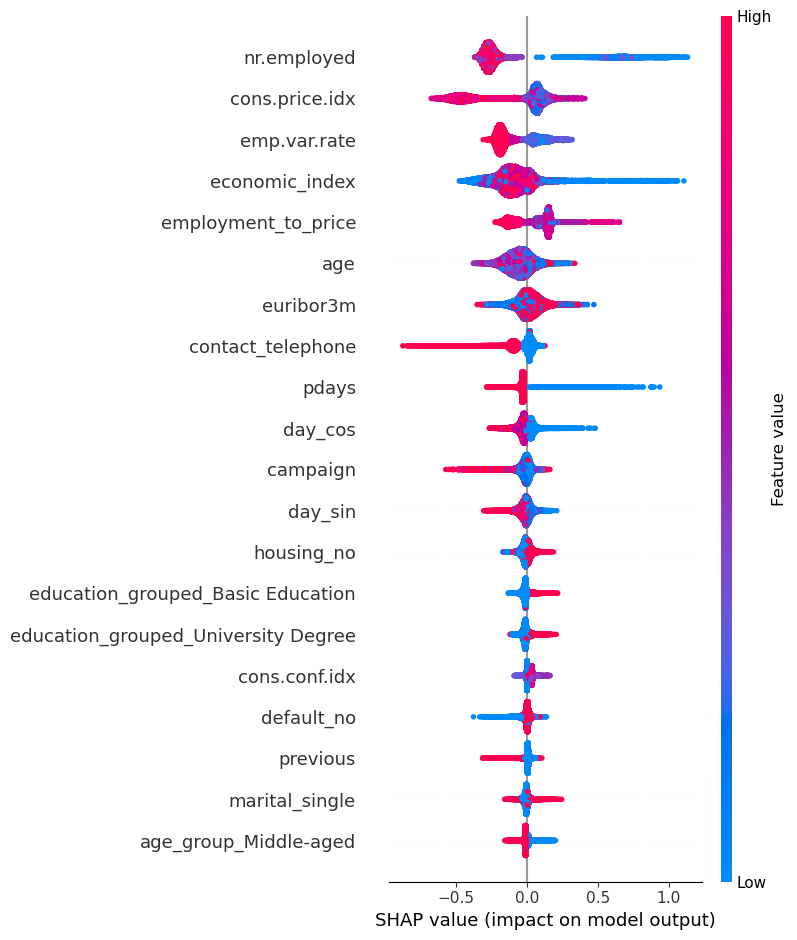

In [60]:
shap.summary_plot(shap_values.values, data_processed_WOstand['train_X'])

- nr.employed, cons.price.idx, and economic_index are the most impactful features, indicating that macroeconomic factors strongly influence deposit decisions
- Both day_cos and day_sin have moderate importance, confirming that time-based patterns contribute to predictions but are secondary to economic indicators.
- Features like education_grouped_University Degree, marital_single, and poutcome_success also play notable roles, highlighting demographic and historical trends in customer behavior.

- Also, according to the chart of the importance, attention should be paid to the age of the client, 

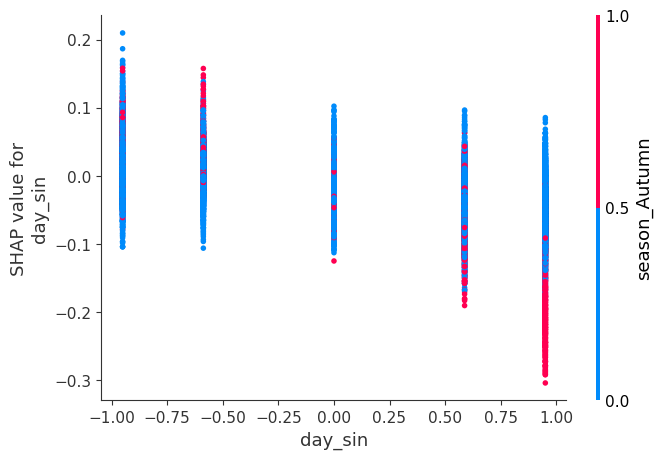

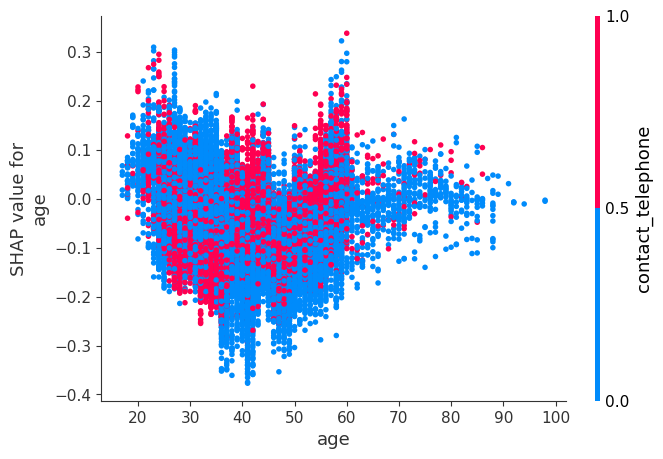

In [63]:
list = [ 'day_sin', 'age']
for i in list:  
    shap.dependence_plot(i, shap_values.values, data_processed_WOstand['train_X'])

In [43]:
df = pd.DataFrame({'day_of_week': ['mon', 'tue', 'wed', 'thu', 'fri']})
day_map = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5}
df['day_num'] = df['day_of_week'].map(day_map)
df['day_sin'] = np.sin(2 * np.pi * df['day_num'] / 5) 
round(df, 3)

,day_of_week,day_num,day_sin
0,mon,1,0.951
1,tue,2,0.588
2,wed,3,-0.588
3,thu,4,-0.951
4,fri,5,-0.000


**Seasonality**: 
- We can see that in autumn we issue the most positive deposits on Mondays (which corresponds to sine 1)
- Whereas in autumn, it is best to make offers on Wednesdays (sine -0.588) for the highest customer approval


**Relationship between 'age', 'contact_telephone'**
- cellular = 0
- The relationship between age and its SHAP value is not linear. 
- At younger ages, a cellular contact (blue) tends to have a negative SHAP value. This suggests that for younger individuals, having a cellular contact is associated with a lower prediction (whatever the model is predicting - e.g., likelihood to subscribe, etc.). Conversely, having a telephone contact (red) at these ages tends to have a slightly positive impact.

In [ ]:
# cellular = 0

In [37]:

instance_idx = 1000

# Generate force plot
shap.initjs()
shap.force_plot(
    explainer.expected_value,  # Expected value for class 1
    shap_values.values[instance_idx], 
    data_processed_WOstand['train_X'].iloc[instance_idx]
)

# Error analysis

In [ ]:

y_prob = model_best_xgb.predict_proba(data_processed_WOstand['val_X'])[:, 1]
threshold = 0.6
y_pred = (y_prob > threshold).astype(int)


df_results = data_processed_WOstand['val_X'].copy()
df_results['target'] = data_processed_WOstand['val_y']
df_results['prediction'] = y_pred
df_results['probability'] = y_prob


df_FP = df_results[(df_results.target != df_results.prediction) & (df_results.prediction == 1)]
df_FN = df_results[(df_results.target != df_results.prediction) & (df_results.prediction == 0)]
df_TP = df_results[(df_results.target == df_results.prediction) & (df_results.prediction == 1)]
df_TN = df_results[(df_results.target == df_results.prediction) & (df_results.prediction == 0)]

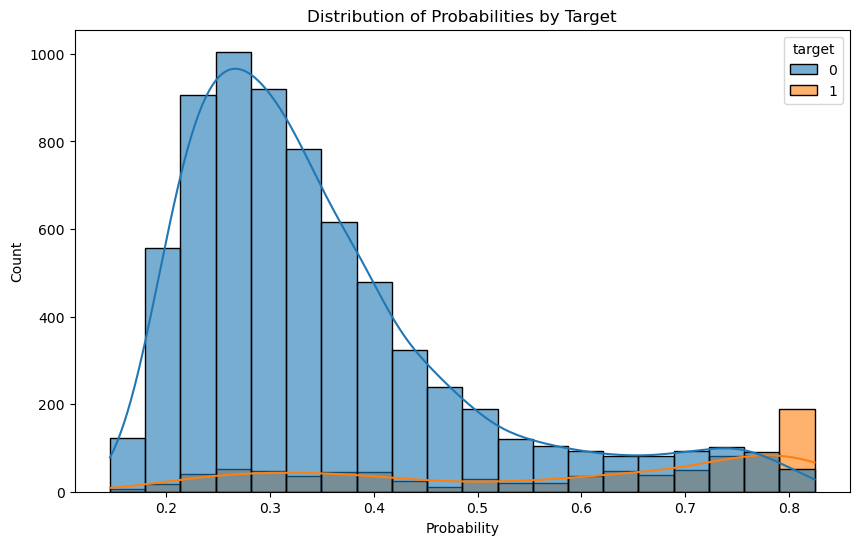

In [103]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_results, x='probability', hue='target', kde=True,  bins=20, alpha=0.6)
plt.title('Distribution of Probabilities by Target')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()

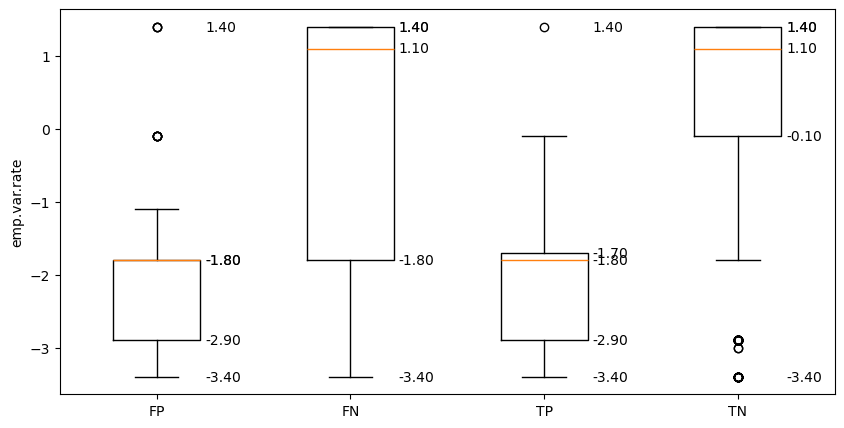

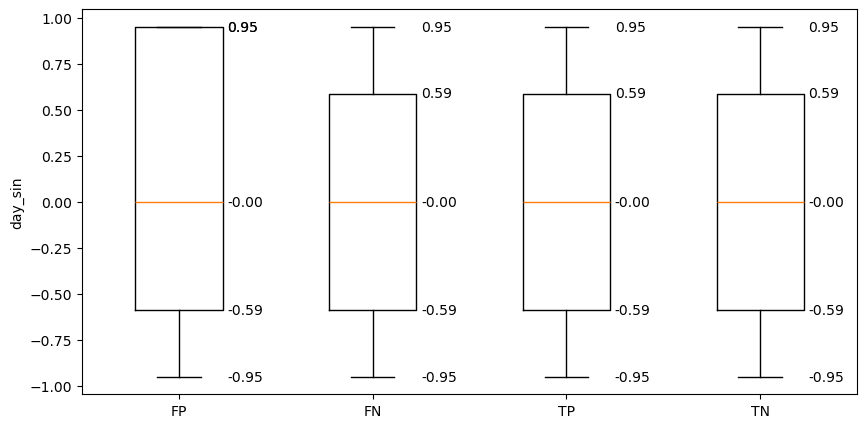

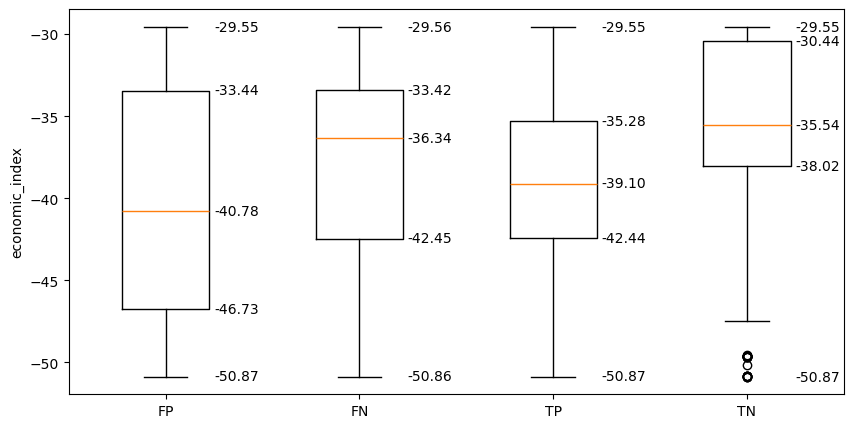

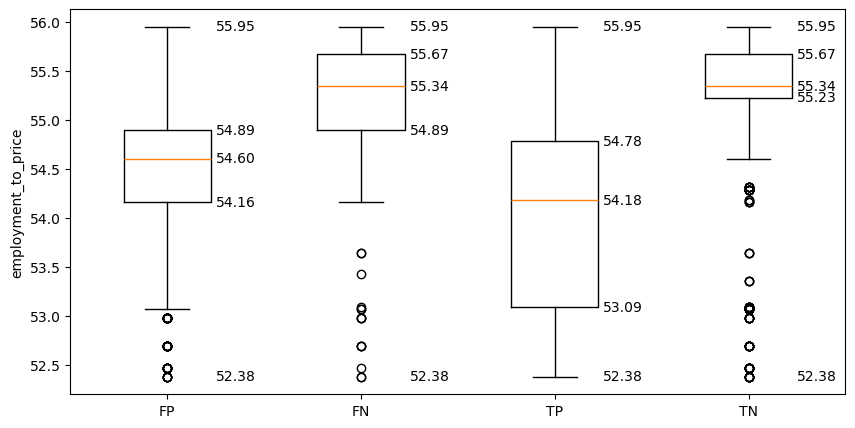

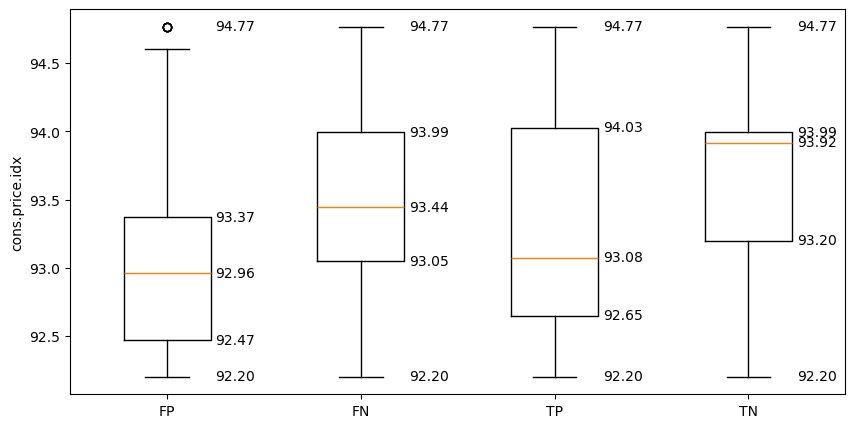

In [124]:
import numpy as np
import matplotlib.pyplot as plt

feature_importance_df_short = ['emp.var.rate', 'day_sin', 'economic_index', 'employment_to_price', 'cons.price.idx']

def calculate_quartiles(data):
    """Calculate quartiles for each group in the data."""
    return [np.percentile(group, [0, 25, 50, 75, 100]) for group in data]

def annotate_quartiles(quartiles, x_offset=1.25):
    """Annotate the boxplot with quartile values."""
    for i, q in enumerate(quartiles):
        for j, percentile in enumerate(q):
            plt.text(i + x_offset, percentile, f'{percentile:.2f}', va='center')

def build_boxplots(feature, data_sets, labels):
    """Build and display boxplots for a given feature."""
    data = [df[feature] for df in data_sets]
    quartiles = calculate_quartiles(data)

    plt.figure(figsize=(10, 5))
    plt.boxplot(data)
    annotate_quartiles(quartiles)

    plt.xticks(range(1, len(labels) + 1), labels)
    plt.ylabel(feature)
    plt.show()

data_sets = [df_FP, df_FN, df_TP, df_TN]
labels = ['FP', 'FN', 'TP', 'TN']

for feature in (feature_importance_df_short):
    build_boxplots(feature, data_sets, labels)